In [1]:
import pandas as pd
import numpy as np
from tqdm import tqdm_notebook as tqdm
from torch.optim.optimizer import Optimizer
import matplotlib.pyplot as plt
from copy import deepcopy
import gc
gc.collect()

9

# jaccard

In [2]:
def get_jaccard_sim(str1, str2): 
    a = set(str1.split()) 
    b = set(str2.split())
    c = a.intersection(b)
    return float(len(c)) / (len(a) + len(b) - len(c))

# MADGRAD

In [3]:
import math
from typing import TYPE_CHECKING, Any, Callable, Optional

if TYPE_CHECKING:
    from torch.optim.optimizer import _params_t
else:
    _params_t = Any

class MADGRAD(Optimizer):

    def __init__(
        self, params: _params_t, lr: float = 1e-2, momentum: float = 0.9, weight_decay: float = 0, eps: float = 1e-6,
    ):
        if momentum < 0 or momentum >= 1:
            raise ValueError(f"Momentum {momentum} must be in the range [0,1]")
        if lr <= 0:
            raise ValueError(f"Learning rate {lr} must be positive")
        if weight_decay < 0:
            raise ValueError(f"Weight decay {weight_decay} must be non-negative")
        if eps < 0:
            raise ValueError(f"Eps must be non-negative")

        defaults = dict(lr=lr, eps=eps, momentum=momentum, weight_decay=weight_decay)
        super().__init__(params, defaults)

    @property
    def supports_memory_efficient_fp16(self) -> bool:
        return False

    @property
    def supports_flat_params(self) -> bool:
        return True

    def step(self, closure: Optional[Callable[[], float]] = None) -> Optional[float]:

        loss = None
        if closure is not None:
            loss = closure()

        if 'k' not in self.state:
            self.state['k'] = torch.tensor([0], dtype=torch.long)
        k = self.state['k'].item()

        for group in self.param_groups:
            eps = group["eps"]
            lr = group["lr"] + eps
            decay = group["weight_decay"]
            momentum = group["momentum"]

            ck = 1 - momentum
            lamb = lr * math.pow(k + 1, 0.5)

            for p in group["params"]:
                if p.grad is None:
                    continue
                grad = p.grad.data
                state = self.state[p]

                if "grad_sum_sq" not in state:
                    state["grad_sum_sq"] = torch.zeros_like(p.data).detach()
                    state["s"] = torch.zeros_like(p.data).detach()
                    if momentum != 0:
                        state["x0"] = torch.clone(p.data).detach()

                if momentum != 0.0 and grad.is_sparse:
                    raise RuntimeError("momentum != 0 is not compatible with sparse gradients")

                grad_sum_sq = state["grad_sum_sq"]
                s = state["s"]

                # Apply weight decay
                if decay != 0:
                    if grad.is_sparse:
                        raise RuntimeError("weight_decay option is not compatible with sparse gradients")

                    grad.add_(p.data, alpha=decay)

                if grad.is_sparse:
                    grad = grad.coalesce()
                    grad_val = grad._values()

                    p_masked = p.sparse_mask(grad)
                    grad_sum_sq_masked = grad_sum_sq.sparse_mask(grad)
                    s_masked = s.sparse_mask(grad)

                    # Compute x_0 from other known quantities
                    rms_masked_vals = grad_sum_sq_masked._values().pow(1 / 3).add_(eps)
                    x0_masked_vals = p_masked._values().addcdiv(s_masked._values(), rms_masked_vals, value=1)

                    # Dense + sparse op
                    grad_sq = grad * grad
                    grad_sum_sq.add_(grad_sq, alpha=lamb)
                    grad_sum_sq_masked.add_(grad_sq, alpha=lamb)

                    rms_masked_vals = grad_sum_sq_masked._values().pow_(1 / 3).add_(eps)

                    s.add_(grad, alpha=lamb)
                    s_masked._values().add_(grad_val, alpha=lamb)

                    # update masked copy of p
                    p_kp1_masked_vals = x0_masked_vals.addcdiv(s_masked._values(), rms_masked_vals, value=-1)
                    # Copy updated masked p to dense p using an add operation
                    p_masked._values().add_(p_kp1_masked_vals, alpha=-1)
                    p.data.add_(p_masked, alpha=-1)
                else:
                    if momentum == 0:
                        # Compute x_0 from other known quantities
                        rms = grad_sum_sq.pow(1 / 3).add_(eps)
                        x0 = p.data.addcdiv(s, rms, value=1)
                    else:
                        x0 = state["x0"]

                    # Accumulate second moments
                    grad_sum_sq.addcmul_(grad, grad, value=lamb)
                    rms = grad_sum_sq.pow(1 / 3).add_(eps)

                    # Update s
                    s.data.add_(grad, alpha=lamb)

                    # Step
                    if momentum == 0:
                        p.data.copy_(x0.addcdiv(s, rms, value=-1))
                    else:
                        z = x0.addcdiv(s, rms, value=-1)

                        # p is a moving average of z
                        p.data.mul_(1 - ck).add_(z, alpha=ck)


        self.state['k'] += 1
        return loss

# LOAD DATA

In [4]:
train_df = pd.read_csv('Train_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward','label_for_train'],axis=1)
print(train_df.shape)
train_df = train_df.dropna(axis=0)
print(train_df.shape)
train_df.head(3)

(1732, 5)
(1732, 5)


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
586,"YUNGSOX 2100M 12MT USD1,015/MT USD12,180 YUNGS...",0,13,YUNGSOX 2100M,855
92,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",0,50,"TRIS 1,2-CYCLOHEXANE DICARBOXYLIC ACID,DI-ISON...",140
91,"TRIS . CIF PORT KLANG,MALAYSIA",0,4,TRIS,139


In [5]:
val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
print(val_df.shape)
val_df = val_df.dropna(axis=0)
print(val_df.shape)
val_df.head(3)

(744, 5)
(744, 5)


,string_X_train,string_Y_1,string_Y_2,Y_label,row_id
1,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,1
2,"COMMODITY: STYRENE MONOMER IN BULKQUANTITY: 3,...",11,34,STYRENE MONOMER IN BULK,2
3,PP 3307UNC1 . TRADE TERMS: CFR ANY JAPANESE PORT,0,2,PP,10


# Model and Tokenizer Initialization

In [6]:
from transformers import DistilBertTokenizerFast
from transformers import DistilBertForQuestionAnswering

tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
gc.collect()

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

284

# Data preprocessing

In [7]:
def preprocessing(df):
    contexts = df['string_X_train'].values.tolist()
    questions = [ 'What is the product name?' for i in range(len(df))]
    answers = []
    for idx in df.index:
        answers.append({
            'text':df.loc[idx,'Y_label'],
            'answer_start':df.loc[idx,'string_Y_1'],
            'answer_end':df.loc[idx,'string_Y_2'],
            })
    return contexts ,questions ,answers

train_contexts ,train_questions ,train_answers = preprocessing(train_df)
val_contexts ,val_questions ,val_answers = preprocessing(val_df)
gc.collect()

0

# tokenize our context/question pairs

In [8]:
train_encodings = tokenizer(train_contexts, train_questions, truncation=True, padding=True)
val_encodings = tokenizer(val_contexts, val_questions, truncation=True, padding=True)
gc.collect()

0

# add_token_positions

In [63]:
def add_token_positions(encodings, answers):
    start_positions = []
    end_positions = []
    for i in range(len(answers)):
        start_positions.append(encodings.char_to_token(i, answers[i]['answer_start']))
        end_positions.append(encodings.char_to_token(i, answers[i]['answer_end'] - 1))

        # if start position is None, the answer passage has been truncated
        if start_positions[-1] is None:
            start_positions[-1] = tokenizer.model_max_length
        if end_positions[-1] is None:
            end_positions[-1] = tokenizer.model_max_length

    encodings.update({'start_positions': start_positions, 'end_positions': end_positions})
    return encodings

train_encodings = add_token_positions(train_encodings, train_answers)
val_encodings = add_token_positions(val_encodings, val_answers)
gc.collect()

20

# data is ready put it in a PyTorch dataset

In [43]:
import torch

class SquadDataset(torch.utils.data.Dataset):
    def __init__(self, encodings):
        self.encodings = encodings

    def __getitem__(self, idx):
        return {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}

    def __len__(self):
        return len(self.encodings.input_ids)

train_dataset = SquadDataset(train_encodings)
val_dataset = SquadDataset(val_encodings)
gc.collect()

20

# train loop

In [14]:
from torch.utils.data import DataLoader
from torch.optim import Adam

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
print(device)
model.to(device)
model.train()
train_loader = DataLoader(train_dataset, batch_size = 32, shuffle=True ,num_workers=4)
val_loader = DataLoader(val_dataset, batch_size = 32, shuffle=True ,num_workers=4)
optimizer = MADGRAD(model.parameters(),lr=5e-5)
gc.collect()

def train_step(model,batch,optimizer):
    model = model.to(device)
    model.train()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    # update model
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()
    
    gc.collect()
    return loss.item()

def val_step(model,batch,optimizer):
    model = model.to(device)
    model.eval()
    # forward
    input_ids = batch['input_ids'].to(device)
    attention_mask = batch['attention_mask'].to(device)
    start_positions = batch['start_positions'].to(device)
    end_positions = batch['end_positions'].to(device)
    outputs = model(input_ids, attention_mask=attention_mask, start_positions=start_positions, end_positions=end_positions)
    loss = outputs[0]
    
    gc.collect()
    return loss.item()

def train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3):
    history = {'train_loss':[],'val_loss':[]}
    best_loss = np.inf
    best_model = None
    not_improve_count = 0
    for epoch in tqdm(range(max_epochs)):    
        # reset this epoch loss equal to zero
        epoch_train_loss = 0.0
        epoch_val_loss = 0.0

        # train one epoch and get train_loss
        for i,batch in enumerate(tqdm(train_loader)):
            epoch_train_loss += train_step(model,batch,optimizer)

        # val one epoch and get val_loss
        for j,batch in enumerate(tqdm(val_loader)):
            epoch_val_loss += val_step(model,batch,optimizer)

        # record loss history
        history['train_loss'].append(epoch_train_loss/i)
        history['val_loss'].append(epoch_val_loss/j)

        # print this epoch's infomation
        print(f'epoch:{epoch} train_loss:{epoch_train_loss/i} val_loss:{epoch_val_loss/j}')

        # save best_model (if current val_loss <= best_loss)
        if history['val_loss'][-1] <= best_loss: 
            best_model = deepcopy(model.eval())
            best_loss = history['val_loss'][-1]
            print(f'save best_model now_val_best_loss is:{best_loss}')

        if history['val_loss'][-1] > best_loss:
            not_improve_count += 1
            print(f'not_improve_count:{not_improve_count}')
            if not_improve_count > patience:
                print('early_stoping')
                break

    # GET best_model.eval()
    model = best_model.eval()
    return model,history

cuda


In [15]:
model,history = train_loop(model,train_loader,val_loader,optimizer,max_epochs=5,patience=3)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/5 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/55 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/24 [00:00<?, ?it/s]

epoch:0 train_loss:0.20870729708285243 val_loss:0.24531751822518266
save best_model now_val_best_loss is:0.24531751822518266


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:1 train_loss:0.1845389877066568 val_loss:0.3747316888007133
not_improve_count:1


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:2 train_loss:0.15829509607067815 val_loss:0.3592659861821195
not_improve_count:2


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:3 train_loss:0.16705761849880219 val_loss:0.3344110558214395
not_improve_count:3


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:4 train_loss:0.1410893260811766 val_loss:0.33395157057953917
not_improve_count:4
early_stoping


# loss curve

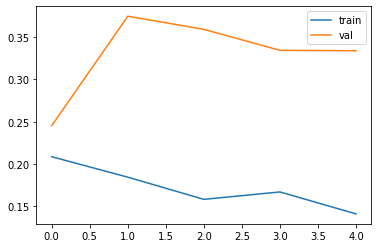

In [16]:
plt.plot(history['train_loss'],label='train')
plt.plot(history['val_loss'],label='val')
plt.legend()
plt.show()

# test

In [17]:
from transformers import pipeline
nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)

In [30]:
def test_model(nlp,df,test_n=30):
    table = pd.DataFrame()
    persudo_val_df = pd.read_csv('Val_Product_Data_2021_0114.csv',index_col=0).drop(['Forward','Backward'],axis=1)
    if test_n != None:
        idx_list = df.sample(test_n).index.tolist()
    else:
        idx_list = df.index.tolist()
    for i in tqdm(idx_list):
        sample = df.loc[[i]]
        string_X_train = sample['string_X_train'].values[0]
        string_Y_1 = sample['string_Y_1'].values[0]
        string_Y_2 = sample['string_Y_2'].values[0]
        QA_input = {
            'question': 'What is the product name?',
            'context': string_X_train
        }
        res = nlp(QA_input)
        predict = QA_input['context'][res['start']:res['end']]
        row = pd.DataFrame({
            'label':string_X_train[string_Y_1:string_Y_2],
            'predict:':predict},index=[i])
        if string_X_train[string_Y_1:string_Y_2] == predict:
            row['是否全對'] = 'Yes'
        else:
            row['是否全對'] = 'No'
        table = table.append(row)
        
        # make persudo label by nlp output 
        persudo_val_df.loc[i]['string_Y_1'] = res['start']
        persudo_val_df.loc[i]['string_Y_2'] = res['end']
        persudo_val_df.loc[i]['Y_label'] = predict
    
    jaccard_avg_score = np.mean([get_jaccard_sim(table.label[i],table['predict:'][i]) for i in table.index])
    
    acc = table['是否全對'].value_counts()['Yes']/len(table)
    
    return table ,jaccard_avg_score ,acc ,persudo_val_df

# 最後讓我們來看看模型在驗證集上的表現

In [35]:
table,jaccard_avg_score,acc,persudo_val_df = test_model(nlp,val_df,test_n=10)
print(f'jaccard_avg_score:{jaccard_avg_score}')
print(f'acc:{acc}')
display(table)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


jaccard_avg_score:0.96
acc:0.9


,label,predict:,是否全對
565,POLYCARBONATE RESIN TARFLON,POLYCARBONATE RESIN TARFLON,Yes
209,POLYPROPYLENE RESIN,POLYPROPYLENE RESIN,Yes
619,PC/ABS,PC/ABS,Yes
613,MONO ETHYLENE GLYCOL,MONO ETHYLENE GLYCOL,Yes
632,ETHYL ACRYLATE,ETHYL ACRYLATE,Yes
563,ABS RESIN,ABS RESIN,Yes
555,HDPE TAISOX 9001,HDPE TAISOX 9001,Yes
669,POLYESTER FILAMENT YARN,POLYESTER FILAMENT YARN,Yes
363,PVC PASTE RESIN PR-F,PVC PASTE RESIN PR-F,Yes
1,STYRENE MONOMER IN BULK,STYRENE MONOMER IN BULKQUANTITY,No


# knowledge distillation

In [64]:
def df2DataLoader(df):
    contexts ,questions ,answers = preprocessing(df)
    encodings = tokenizer(contexts, questions, truncation=True, padding=True)
    encodings = add_token_positions(encodings, answers)
    dataset = SquadDataset(encodings)
    dataloader = DataLoader(dataset, batch_size = 32, shuffle=True ,num_workers=4)
    return dataloader

In [65]:
gc.collect()
def knowledge_distillation(n=3):
    # initialize
    tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')
    model = DistilBertForQuestionAnswering.from_pretrained("distilbert-base-uncased")
    device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
    print(device)
    model.to(device)
    train_df_extra_loader = train_loader
    for i in range(n):
        # 1.training model
        optimizer = MADGRAD(model.parameters(),lr=5e-5) # Adam(model.parameters(),lr=5e-5)
        model,history = train_loop(model,train_df_extra_loader,val_loader,optimizer,max_epochs=3,patience=1)
        nlp = pipeline('question-answering', model=model.to('cpu'), tokenizer=tokenizer)
        # 2.cacluate model score and get persudo_val_df(by trained_model)
        table,jaccard_avg_score,acc,persudo_val_df = test_model(nlp,val_df,test_n=10)
        # 3.add persudo_val_df to train_df
        train_df_extra = train_df.append(persudo_val_df).reset_index(drop=True)
        # 4.make train_df_extra_loader
        train_df_extra_loader = df2DataLoader(train_df_extra)
        model = model.to(device)
        gc.collect()
    # end for 
    return model

In [66]:
knowledge_distillation_model = knowledge_distillation(n=3)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForQuestionAnswering: ['vocab_transform.weight', 'vocab_projector.bias', 'vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForQuestionAnswering from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForQuestionAnswering were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['qa_outputs.weight', 'qa_outputs.bias']
You should probably TRAIN this mode

cuda


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:51: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/3 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:57: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/55 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:61: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


  0%|          | 0/24 [00:00<?, ?it/s]

epoch:0 train_loss:1.7651982103232984 val_loss:0.2908528492502544
save best_model now_val_best_loss is:0.2908528492502544


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:1 train_loss:0.44700234604102596 val_loss:0.27131527516504994
save best_model now_val_best_loss is:0.27131527516504994


  0%|          | 0/55 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:2 train_loss:0.32144510249296826 val_loss:0.24382094423408093
save best_model now_val_best_loss is:0.24382094423408093


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/10 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:0 train_loss:0.24773969636722046 val_loss:0.13119585447661256
save best_model now_val_best_loss is:0.13119585447661256


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:1 train_loss:0.2219478694068921 val_loss:0.1299715834143369
save best_model now_val_best_loss is:0.1299715834143369


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:2 train_loss:0.21842185371591674 val_loss:0.1072299956627514
save best_model now_val_best_loss is:0.1072299956627514


  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:0 train_loss:0.16113613606370114 val_loss:0.07889590890187284
save best_model now_val_best_loss is:0.07889590890187284


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:1 train_loss:0.148646378284925 val_loss:0.06496646660177605
save best_model now_val_best_loss is:0.06496646660177605


  0%|          | 0/78 [00:00<?, ?it/s]

  0%|          | 0/24 [00:00<?, ?it/s]

epoch:2 train_loss:0.1312157591054966 val_loss:0.07474101484631715
not_improve_count:1


  0%|          | 0/10 [00:00<?, ?it/s]

In [67]:
knowledge_distillation_model = knowledge_distillation_model.eval()

In [68]:
nlp = pipeline('question-answering', model=knowledge_distillation_model.to('cpu'), tokenizer=tokenizer)

In [69]:
table,jaccard_avg_score,acc,persudo_val_df = test_model(nlp,val_df,test_n=30)
print(f'jaccard_avg_score:{jaccard_avg_score}')
print(f'acc:{acc}')
display(table)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/30 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


jaccard_avg_score:0.9305555555555555
acc:0.8333333333333334


,label,predict:,是否全對
112,PP FILM,PP FILM,Yes
689,HIPS,HIPS,Yes
324,EPOXY RESIN,EPOXY RESIN,Yes
301,GASOIL,GASOIL,Yes
597,POLYPROPYLENE RESIN,POLYPROPYLENE RESIN,Yes
264,PP RESIN,PP RESIN,Yes
7,TAISOX EVA 7350M,TAISOX EVA 7350MQUANTITY,No
642,MONO ETHYLENE GLYCOL,MONO ETHYLENE GLYCOLPACKING,No
93,PURIFIED ISOPHTHALIC ACID,PURIFIED ISOPHTHALIC ACID,Yes
508,ACETONITRILE,ACETONITRILE,Yes


In [70]:
table,jaccard_avg_score,acc,persudo_val_df = test_model(nlp,val_df,test_n=len(val_df))
print(f'jaccard_avg_score:{jaccard_avg_score}')
print(f'acc:{acc}')
display(table)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:8: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


  0%|          | 0/744 [00:00<?, ?it/s]

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


jaccard_avg_score:0.9254032258064516
acc:0.8588709677419355


,label,predict:,是否全對
8,TAISOX EVA 7320M,TAISOX EVA 7320MQUANTITY,No
520,METHYL METHACRYLATE,METHYL METHACRYLATE,Yes
228,ETHYLENE-PROPYLENE COPOLYMERS,ETHYLENE-PROPYLENE COPOLYMERS,Yes
211,MONOETHYLENE GLYCOL MEG,MONOETHYLENE GLYCOL,No
41,PROPYLENE COPOLYMER,PROPYLENE COPOLYMER,Yes
...,...,...,...
542,MALEIC ANHYDRIDE,MALEIC ANHYDRIDE,Yes
623,ABS,ABS,Yes
274,POLYESTER STAPLE FIBER,POLYESTER STAPLE FIBER,Yes
360,ACRYLONITRILE BUTADIENE STYRENE RESIN,ACRYLONITRILE BUTADIENE STYRENE RESIN,Yes
